## Fourier Neural Operator 1D

In [1]:
## Imports 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import torch.nn as nn
from timeit import default_timer

c:\Users\Harris\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Set seeds
torch.manual_seed(0)
np.random.seed(0)

## Create Data

### Ordinary Differential Equation:

\begin{align*}
m\frac{d^2x}{dt^2} = - kx
\end{align*}

Solution: 
$$x(t) = x_0 \cos{\left(\sqrt{\frac{k}{m}}t\right)} + \frac{v_0}{\sqrt{\frac{k}{m}}}\sin{\left(\sqrt{\frac{k}{m}}t\right)}$$

In [3]:
## TODO: Create Simple Harmonic Oscillator Class

In [4]:
## Simple Harmonic Oscillator
def simple_harmonic_oscillator(k: int, m: int, x0: int, v0: int, t: np.array) -> np.array:
    x = x0 * np.cos(np.sqrt(k / m) * t) + (v0 / np.sqrt(k / m)) * np.sin(np.sqrt(k / m) * t)
    return x    

In [5]:
## Number of Samples 
n = 100000
## Output
data_t = []
data_x = []

# k = np.random.randint(1, 100)
# m = np.random.randint(1, 100)
# x0 = np.random.normal(0, 10)
# v0 = np.random.normal(0, 10)
k = 1
m = 1000
# x0 = 1
v0 = 1

## Generate Data
for _ in range(n):
    # k = np.random.randint(1, 100)
    # m = np.random.randint(1, 100)
    x0 = np.random.normal(0, 10)
    # v0 = np.random.normal(0, 1)
    
    t = np.random.uniform(0, 100)
    data_t.append([[x0], [t]])
    data_x.append(simple_harmonic_oscillator(k, m, x0, v0, t))

In [6]:
## Plot
# plt.scatter(data_t, data_x, alpha=0.5)
# plt.show()

In [7]:
data_t = np.array(torch.tensor(data_t).float())
data_x = np.array(torch.tensor(data_x).float().unsqueeze(1).unsqueeze(1))

In [8]:
## Data Loader
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, t, x):
        self.t = t
        self.x = x

    def __len__(self):
        return len(self.t)
    
    def __getitem__(self, index):
        return self.t[index], self.x[index]

data = CustomDataset(data_t, data_x)

In [9]:
data[0][0]

array([[17.640524],
       [60.276337]], dtype=float32)

In [10]:
data[0][0].shape

(2, 1)

In [11]:
dataloader = DataLoader(data, batch_size=64, shuffle=True)

## Build Network

In [12]:
## Get Device for Training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

Using cpu device.


In [13]:
## Fourier Integral Kernel 1D
class FourierIntegralKernel1D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(FourierIntegralKernel1D, self).__init__()
        '''
        '''
        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.modes = modes 
        ## Set (random) weights for the linear transform
        weights = torch.rand(self.modes, self.out_channels, self.in_channels, dtype=torch.cfloat) 
        self.weights = nn.Parameter(weights / (self.in_channels * self.out_channels)) ## Optional: Scale weights

    def forward(self, v: torch.Tensor) -> torch.Tensor:
        '''
        FFT -> Linear Transform -> Inverse FFT
        '''
        ## FFT
        v_rfft = torch.fft.rfft(v) 

        ## Linear Transform 
        lv_rfft = torch.zeros(v_rfft.shape, dtype=torch.cfloat)
        lv_rfft[:, :, :self.modes] = torch.einsum('koi, bki -> bko', self.weights, v_rfft[:, :, :self.modes].permute(0, 2, 1)).permute(0, 2, 1) ## TODO: Should I have 5 dimensions here?
        
        ## Inverse FFT
        v2 = torch.fft.irfft(lv_rfft, n=v.shape[-1])
        return v2
        

In [14]:
## Fourier Network Operator 1D
class FourierNetworkOperator1D(nn.Module):
    def __init__(self, da: int, du: int, width: int, modes: int):
        super(FourierNetworkOperator1D, self).__init__()
        '''
        '''
        self.width = width
        self.modes = modes

        ## P: Lifts the lower dimensional function to higher dimensional space
        self.P = nn.Conv1d(da, self.width, 1) ## TODO: Change da

        ## K: Fourier integral kernel operator
        self.k0 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k1 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k2 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k3 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        # self.k4 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        # self.k5 = FourierIntegralKernel1D(self.width, self.width, self.modes)

        ## W: Pointwise linear operator
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        # self.w4 = nn.Conv1d(self.width, self.width, 1)
        # self.w5 = nn.Conv1d(self.width, self.width, 1)

        ## Q: Projects the higher dimensional function to lower dimensional space
        self.Q = nn.Conv1d(self.width, du, 1) ## TODO: Change du

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        '''
        ## P
        x = self.P(x)

        ## Fourier Layer #0
        ## K
        x1 = self.k0(x)
        ## W
        x2 = self.w0(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #1
        ## K
        x1 = self.k1(x)
        ## W
        x2 = self.w1(x)
        ## Sum 
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #2
        ## K
        x1 = self.k2(x)
        ## W
        x2 = self.w2(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #3
        ## K
        x1 = self.k3(x)
        ## W
        x2 = self.w3(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        # ## Fourier Layer #4
        # ## K
        # x1 = self.k4(x)
        # ## W
        # x2 = self.w4(x)
        # ## Sum
        # x = x1 + x2
        # ## Gelu
        # x = nn.functional.gelu(x)
        # # x = nn.functional.gelu(x1)
        # # x = nn.functional.gelu(x2)

        # ## Fourier Layer #5
        # ## K
        # x1 = self.k5(x)
        # ## W
        # x2 = self.w5(x)
        # ## Sum
        # x = x1 + x2
        # ## Gelu
        # x = nn.functional.gelu(x)
        # # x = nn.functional.gelu(x1)
        # # x = nn.functional.gelu(x2)

        ## Q
        x = self.Q(x)
        return x


In [15]:
import operator
from functools import reduce

def count_parameters(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size() + (2, ) if p.is_complex() else p.size()))
    return c

model = FourierNetworkOperator1D(2, 1, width=64, modes=1)
print(f'Number of parameters: {count_parameters(model)}')

Number of parameters: 49665


## Train

In [16]:
## Model Parameters
learning_rate = 1e-3
epochs = 5

In [17]:
## Loss Function
loss_function = nn.MSELoss()

In [18]:
## Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

x0: 6.606366847641208


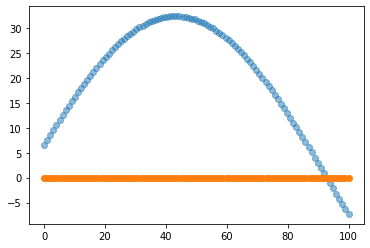

In [19]:
## Test 0
# k = np.random.randint(1, 100)
# m = np.random.randint(1, 100)

x0 = np.random.normal(0, 10)
print(f'x0: {x0}')
x0_vec = torch.from_numpy(x0 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

# v0 = np.random.normal(0, 1)
# print(f'v0: {v0}')
# v0_vec = torch.from_numpy(v0 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

t_test = torch.from_numpy(np.linspace(0, 100, 100)).float().unsqueeze(0).unsqueeze(0)
x0_test = simple_harmonic_oscillator(k, m, x0, v0, t_test)

plt.scatter(t_test, x0_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((x0_vec, t_test), 1).permute(2, 1, 0)).detach())
plt.show()

x0: -0.032098141219407336


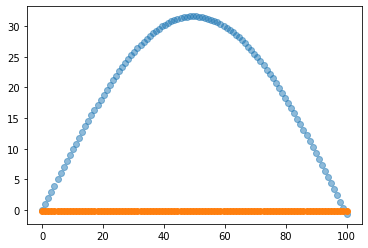

In [20]:
## Test 1
# k = np.random.randint(1, 100)
# m = np.random.randint(1, 100)

x1 = np.random.normal(0, 10)
print(f'x0: {x1}')
x1_vec = torch.from_numpy(x1 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

# v1 = np.random.normal(0, 1)
# print(f'v0: {v1}')
# v1_vec = torch.from_numpy(v1 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)


t_test = torch.from_numpy(np.linspace(0, 100, 100)).float().unsqueeze(0).unsqueeze(0)
x1_test = simple_harmonic_oscillator(k, m, x1, v0, t_test)

plt.scatter(t_test, x1_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((x1_vec, t_test), 1).permute(2, 1, 0)).detach())
plt.show()

x0: 6.305686614165824


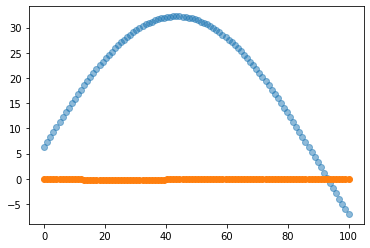

In [21]:
## Test 2
# k = np.random.randint(1, 100)
# m = np.random.randint(1, 100)

x2 = np.random.normal(0, 10)
print(f'x0: {x2}')
x2_vec = torch.from_numpy(x2 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

# v2 = np.random.normal(0, 1)
# print(f'v0: {v2}')
# v2_vec = torch.from_numpy(v2 * np.ones(100)).float().unsqueeze(0).unsqueeze(0)

t_test= torch.from_numpy(np.linspace(0, 100, 100)).float().unsqueeze(0).unsqueeze(0)
x2_test = simple_harmonic_oscillator(k, m, x2, v0, t_test)

plt.scatter(t_test, x2_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((x2_vec, t_test), 1).permute(2, 1, 0)).detach())
plt.show()

In [22]:
## Training Loop
def train_loop(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    for batch, (t, x) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(t)
        loss = loss_function(pred, x)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(t)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [23]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, model, loss_function, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 542.742004  [    0/100000]
loss: 130.713196  [ 6400/100000]
loss: 141.922913  [12800/100000]
loss: 83.293068  [19200/100000]
loss: 59.935493  [25600/100000]
loss: 7.310755  [32000/100000]
loss: 4.008781  [38400/100000]
loss: 2.483137  [44800/100000]
loss: 3.642902  [51200/100000]
loss: 2.180079  [57600/100000]
loss: 0.319112  [64000/100000]
loss: 0.653924  [70400/100000]
loss: 0.425824  [76800/100000]
loss: 0.208914  [83200/100000]
loss: 0.941770  [89600/100000]
loss: 1.719457  [96000/100000]
Epoch 2
-------------------------------
loss: 0.439712  [    0/100000]
loss: 0.346799  [ 6400/100000]
loss: 0.470843  [12800/100000]
loss: 0.343686  [19200/100000]
loss: 0.153149  [25600/100000]
loss: 0.374912  [32000/100000]
loss: 0.427144  [38400/100000]
loss: 0.678505  [44800/100000]
loss: 0.539098  [51200/100000]
loss: 0.663535  [57600/100000]
loss: 0.552299  [64000/100000]
loss: 0.454131  [70400/100000]
loss: 3.528792  [76800/100000]
loss: 0.02352

## Test

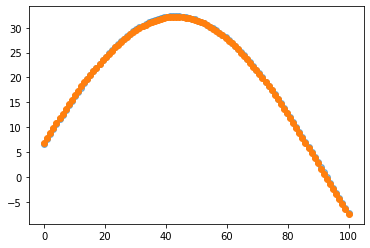

In [24]:
## Test 0
plt.scatter(t_test, x0_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((x0_vec, t_test), 1).permute(2, 1, 0)).detach())
plt.show()

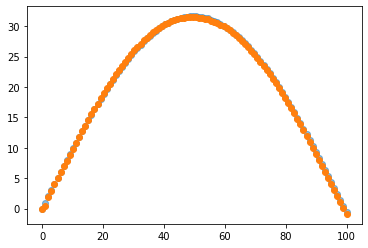

In [25]:
## Test 1
plt.scatter(t_test, x1_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((x1_vec, t_test), 1).permute(2, 1, 0)).detach())
plt.show()

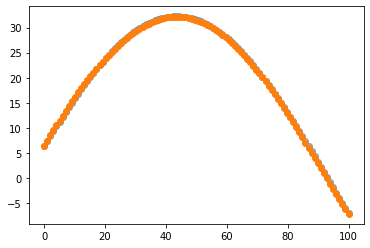

In [26]:
## Test 2
plt.scatter(t_test, x2_test, alpha=0.5)
plt.scatter(t_test, model(torch.cat((x2_vec, t_test), 1).permute(2, 1, 0)).detach())
plt.show()